In [ ]:
# Mount Google Drive (run this cell first in Colab)
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import os

# --------------------------
# 1. Load and Prepare Dataset
# --------------------------
file_path = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 35.xlsx"
df = pd.read_excel(file_path)

# Check for required columns
required_columns = ["Return_Next 3M", "Timestamp", "PERMNO"]
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' is missing in the Final 35 database.")

# Drop rows where the target is missing
df = df.dropna(subset=["Return_Next 3M"]).reset_index(drop=True)

# Ensure Timestamp is an integer (if it isn’t already)
df["Timestamp"] = df["Timestamp"].astype(int)

# --------------------------
# 2. Create a Binary Target for Logistic Regression
# --------------------------
# For logistic regression, we need a binary outcome.
# In this example, we classify a record as 1 if the return is positive, else 0.
df["target"] = (df["Return_Next 3M"] > 0).astype(int)

# --------------------------
# 3. Define Feature Variables
# --------------------------
# We assume that the first few columns (e.g., "Return_Next 3M", "Timestamp", "PERMNO", and now "target")
# are non-feature columns. The remaining columns will be used as predictors.
non_feature_cols = ["Return_Next 3M", "Timestamp", "PERMNO", "target"]
x_vars = [col for col in df.columns if col not in non_feature_cols]

# --------------------------
# 4. Define Moving Window Parameters and Time Splits
# --------------------------
# Define window lengths (in terms of unique timestamp units, e.g., months)
rolling_window = 36      # Training period: 36 time units
validation_period = 3    # Validation period: next 3 time units
test_period = 2          # Test period: following 2 time units

# Get unique sorted timestamps
timestamps = sorted(df["Timestamp"].unique())

# Storage for results and predictions
results = []

# --------------------------
# 5. Moving Window Loop (Avoiding Data Leakage)
# --------------------------
# Loop over the timestamps such that each iteration defines a training, validation, and test set.
for i in range(len(timestamps) - rolling_window - validation_period - test_period + 1):
    # Define time boundaries for each split:
    train_start = timestamps[i]
    train_end = timestamps[i + rolling_window - 1]
    validation_start = timestamps[i + rolling_window]
    validation_end = timestamps[i + rolling_window + validation_period - 1]
    test_start = timestamps[i + rolling_window + validation_period]
    test_end = timestamps[i + rolling_window + validation_period + test_period - 1]

    # Select data for each period based on Timestamp
    train_data = df[(df["Timestamp"] >= train_start) & (df["Timestamp"] <= train_end)]
    validation_data = df[(df["Timestamp"] >= validation_start) & (df["Timestamp"] <= validation_end)]
    test_data = df[(df["Timestamp"] >= test_start) & (df["Timestamp"] <= test_end)]

    # Print summary of counts for debugging
    print(f"Processing Window Ending at Timestamp {train_end} | "
          f"Train: {len(train_data)}, Validation: {len(validation_data)}, Test: {len(test_data)}")

    # Skip this window if any period lacks sufficient data
    if len(train_data) < rolling_window or len(validation_data) == 0 or len(test_data) == 0:
        print(f"Skipping window ending at {train_end} due to insufficient data.")
        continue

    # Prepare feature (X) and target (y) matrices for each split
    X_train = train_data[x_vars]
    y_train = train_data["target"]
    X_val = validation_data[x_vars]
    y_val = validation_data["target"]
    X_test = test_data[x_vars]
    y_test = test_data["target"]

    # Check for any missing values in training data
    if X_train.isnull().values.any() or y_train.isnull().values.any():
        print(f"Skipping window ending at {train_end} due to NaN values in training data.")
        continue

    # Optional: Check that y_train is not constant
    if y_train.nunique() == 1:
        print(f"Skipping window ending at {train_end} due to constant target variable in training data.")
        continue

    # --------------------------
    # 6. Model Estimation with Logistic Regression
    # --------------------------
    # Instantiate and fit a logistic regression model (using default regularization)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # Generate predictions and predicted probabilities for validation and test sets
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    val_probs = model.predict_proba(X_val)[:, 1]  # probability for class 1
    test_probs = model.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics for both splits
    val_accuracy = accuracy_score(y_val, y_val_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    try:
        val_roc_auc = roc_auc_score(y_val, val_probs)
        test_roc_auc = roc_auc_score(y_test, test_probs)
    except ValueError:
        # In case one of the classes is missing in y_val or y_test
        val_roc_auc = np.nan
        test_roc_auc = np.nan

    # Store predictions and metrics for further analysis
    results.append({
        "train_end": train_end,
        "validation_accuracy": val_accuracy,
        "test_accuracy": test_accuracy,
        "validation_roc_auc": val_roc_auc,
        "test_roc_auc": test_roc_auc,
        "model": model,  # saved for debugging if needed
        "validation_data": validation_data.assign(predicted_prob=val_probs),
        "test_data": test_data.assign(predicted_prob=test_probs)
    })

    print(f"Window ending {train_end}: Val Acc = {val_accuracy:.2f}, Test Acc = {test_accuracy:.2f}, "
          f"Val ROC-AUC = {val_roc_auc:.2f}, Test ROC-AUC = {test_roc_auc:.2f}")

# --------------------------
# 7. Finalize and Save Results as Final 48.xlsx
# --------------------------
if len(results) == 0:
    raise ValueError("No valid predictions were generated. Check the moving window parameters or data quality.")

# Combine validation and test predictions from all windows for further analysis
all_val_preds = pd.concat([res["validation_data"] for res in results], ignore_index=True)
all_test_preds = pd.concat([res["test_data"] for res in results], ignore_index=True)

# Save predictions to a single Excel file with separate sheets for Validation and Test results
output_file = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 48.xlsx"
with pd.ExcelWriter(output_file) as writer:
    all_val_preds.to_excel(writer, sheet_name='Validation', index=False)
    all_test_preds.to_excel(writer, sheet_name='Test', index=False)

print(f"✅ Logistic Regression on a Moving Window Completed!")
print(f"Results saved as: {output_file}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing Window Ending at Timestamp 200512 | Train: 14986, Validation: 1272, Test: 862


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200512: Val Acc = 0.53, Test Acc = 0.44, Val ROC-AUC = 0.59, Test ROC-AUC = 0.54
Processing Window Ending at Timestamp 200601 | Train: 14997, Validation: 1282, Test: 862


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200601: Val Acc = 0.45, Test Acc = 0.56, Val ROC-AUC = 0.63, Test ROC-AUC = 0.41
Processing Window Ending at Timestamp 200602 | Train: 15007, Validation: 1289, Test: 863


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200602: Val Acc = 0.45, Test Acc = 0.71, Val ROC-AUC = 0.56, Test ROC-AUC = 0.31
Processing Window Ending at Timestamp 200603 | Train: 15019, Validation: 1293, Test: 865


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200603: Val Acc = 0.50, Test Acc = 0.85, Val ROC-AUC = 0.48, Test ROC-AUC = 0.37
Processing Window Ending at Timestamp 200604 | Train: 15036, Validation: 1294, Test: 864


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200604: Val Acc = 0.64, Test Acc = 0.86, Val ROC-AUC = 0.41, Test ROC-AUC = 0.56
Processing Window Ending at Timestamp 200605 | Train: 15054, Validation: 1296, Test: 866


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200605: Val Acc = 0.75, Test Acc = 0.80, Val ROC-AUC = 0.38, Test ROC-AUC = 0.60
Processing Window Ending at Timestamp 200606 | Train: 15072, Validation: 1296, Test: 872


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200606: Val Acc = 0.84, Test Acc = 0.72, Val ROC-AUC = 0.44, Test ROC-AUC = 0.53
Processing Window Ending at Timestamp 200607 | Train: 15091, Validation: 1299, Test: 880


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200607: Val Acc = 0.83, Test Acc = 0.66, Val ROC-AUC = 0.56, Test ROC-AUC = 0.54
Processing Window Ending at Timestamp 200608 | Train: 15110, Validation: 1303, Test: 887


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200608: Val Acc = 0.76, Test Acc = 0.68, Val ROC-AUC = 0.55, Test ROC-AUC = 0.63
Processing Window Ending at Timestamp 200609 | Train: 15128, Validation: 1315, Test: 889


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200609: Val Acc = 0.71, Test Acc = 0.76, Val ROC-AUC = 0.57, Test ROC-AUC = 0.64
Processing Window Ending at Timestamp 200610 | Train: 15149, Validation: 1324, Test: 889


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200610: Val Acc = 0.68, Test Acc = 0.78, Val ROC-AUC = 0.60, Test ROC-AUC = 0.56
Processing Window Ending at Timestamp 200611 | Train: 15174, Validation: 1332, Test: 888


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200611: Val Acc = 0.74, Test Acc = 0.58, Val ROC-AUC = 0.65, Test ROC-AUC = 0.51
Processing Window Ending at Timestamp 200612 | Train: 15205, Validation: 1333, Test: 888


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200612: Val Acc = 0.76, Test Acc = 0.39, Val ROC-AUC = 0.60, Test ROC-AUC = 0.52
Processing Window Ending at Timestamp 200701 | Train: 15238, Validation: 1333, Test: 893


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200701: Val Acc = 0.66, Test Acc = 0.42, Val ROC-AUC = 0.55, Test ROC-AUC = 0.56
Processing Window Ending at Timestamp 200702 | Train: 15269, Validation: 1332, Test: 898


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200702: Val Acc = 0.50, Test Acc = 0.59, Val ROC-AUC = 0.53, Test ROC-AUC = 0.61
Processing Window Ending at Timestamp 200703 | Train: 15297, Validation: 1337, Test: 897


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200703: Val Acc = 0.43, Test Acc = 0.59, Val ROC-AUC = 0.55, Test ROC-AUC = 0.64
Processing Window Ending at Timestamp 200704 | Train: 15325, Validation: 1342, Test: 896


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200704: Val Acc = 0.51, Test Acc = 0.48, Val ROC-AUC = 0.58, Test ROC-AUC = 0.66
Processing Window Ending at Timestamp 200705 | Train: 15352, Validation: 1346, Test: 896


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200705: Val Acc = 0.56, Test Acc = 0.31, Val ROC-AUC = 0.62, Test ROC-AUC = 0.63
Processing Window Ending at Timestamp 200706 | Train: 15385, Validation: 1345, Test: 895


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200706: Val Acc = 0.54, Test Acc = 0.23, Val ROC-AUC = 0.65, Test ROC-AUC = 0.60
Processing Window Ending at Timestamp 200707 | Train: 15418, Validation: 1344, Test: 897


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200707: Val Acc = 0.38, Test Acc = 0.28, Val ROC-AUC = 0.63, Test ROC-AUC = 0.58
Processing Window Ending at Timestamp 200708 | Train: 15448, Validation: 1343, Test: 899


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200708: Val Acc = 0.30, Test Acc = 0.44, Val ROC-AUC = 0.63, Test ROC-AUC = 0.54
Processing Window Ending at Timestamp 200709 | Train: 15478, Validation: 1345, Test: 898


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200709: Val Acc = 0.26, Test Acc = 0.67, Val ROC-AUC = 0.57, Test ROC-AUC = 0.59
Processing Window Ending at Timestamp 200710 | Train: 15507, Validation: 1346, Test: 898


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200710: Val Acc = 0.42, Test Acc = 0.62, Val ROC-AUC = 0.56, Test ROC-AUC = 0.61
Processing Window Ending at Timestamp 200711 | Train: 15537, Validation: 1348, Test: 897


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200711: Val Acc = 0.56, Test Acc = 0.42, Val ROC-AUC = 0.55, Test ROC-AUC = 0.56
Processing Window Ending at Timestamp 200712 | Train: 15570, Validation: 1347, Test: 898


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200712: Val Acc = 0.61, Test Acc = 0.34, Val ROC-AUC = 0.60, Test ROC-AUC = 0.47
Processing Window Ending at Timestamp 200801 | Train: 15602, Validation: 1346, Test: 900


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200801: Val Acc = 0.53, Test Acc = 0.36, Val ROC-AUC = 0.58, Test ROC-AUC = 0.41
Processing Window Ending at Timestamp 200802 | Train: 15633, Validation: 1347, Test: 901


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200802: Val Acc = 0.38, Test Acc = 0.26, Val ROC-AUC = 0.53, Test ROC-AUC = 0.42
Processing Window Ending at Timestamp 200803 | Train: 15660, Validation: 1348, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200803: Val Acc = 0.36, Test Acc = 0.12, Val ROC-AUC = 0.43, Test ROC-AUC = 0.56
Processing Window Ending at Timestamp 200804 | Train: 15686, Validation: 1351, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200804: Val Acc = 0.28, Test Acc = 0.17, Val ROC-AUC = 0.41, Test ROC-AUC = 0.58
Processing Window Ending at Timestamp 200805 | Train: 15714, Validation: 1352, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200805: Val Acc = 0.27, Test Acc = 0.31, Val ROC-AUC = 0.45, Test ROC-AUC = 0.53
Processing Window Ending at Timestamp 200806 | Train: 15743, Validation: 1353, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200806: Val Acc = 0.18, Test Acc = 0.31, Val ROC-AUC = 0.59, Test ROC-AUC = 0.46
Processing Window Ending at Timestamp 200807 | Train: 15776, Validation: 1353, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200807: Val Acc = 0.27, Test Acc = 0.33, Val ROC-AUC = 0.57, Test ROC-AUC = 0.38
Processing Window Ending at Timestamp 200808 | Train: 15809, Validation: 1353, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200808: Val Acc = 0.44, Test Acc = 0.41, Val ROC-AUC = 0.50, Test ROC-AUC = 0.37
Processing Window Ending at Timestamp 200809 | Train: 15843, Validation: 1353, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200809: Val Acc = 0.43, Test Acc = 0.44, Val ROC-AUC = 0.45, Test ROC-AUC = 0.28
Processing Window Ending at Timestamp 200810 | Train: 15874, Validation: 1353, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200810: Val Acc = 0.39, Test Acc = 0.49, Val ROC-AUC = 0.39, Test ROC-AUC = 0.36
Processing Window Ending at Timestamp 200811 | Train: 15906, Validation: 1353, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200811: Val Acc = 0.41, Test Acc = 0.50, Val ROC-AUC = 0.37, Test ROC-AUC = 0.48
Processing Window Ending at Timestamp 200812 | Train: 15937, Validation: 1353, Test: 900


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200812: Val Acc = 0.34, Test Acc = 0.36, Val ROC-AUC = 0.34, Test ROC-AUC = 0.48
Processing Window Ending at Timestamp 200901 | Train: 15967, Validation: 1353, Test: 898


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200901: Val Acc = 0.38, Test Acc = 0.34, Val ROC-AUC = 0.46, Test ROC-AUC = 0.46
Processing Window Ending at Timestamp 200902 | Train: 15994, Validation: 1351, Test: 898


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200902: Val Acc = 0.37, Test Acc = 0.41, Val ROC-AUC = 0.49, Test ROC-AUC = 0.52
Processing Window Ending at Timestamp 200903 | Train: 16018, Validation: 1349, Test: 899


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200903: Val Acc = 0.51, Test Acc = 0.55, Val ROC-AUC = 0.49, Test ROC-AUC = 0.52
Processing Window Ending at Timestamp 200904 | Train: 16038, Validation: 1347, Test: 900


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200904: Val Acc = 0.74, Test Acc = 0.69, Val ROC-AUC = 0.48, Test ROC-AUC = 0.50
Processing Window Ending at Timestamp 200905 | Train: 16056, Validation: 1348, Test: 900


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200905: Val Acc = 0.77, Test Acc = 0.71, Val ROC-AUC = 0.52, Test ROC-AUC = 0.47
Processing Window Ending at Timestamp 200906 | Train: 16074, Validation: 1349, Test: 900


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200906: Val Acc = 0.74, Test Acc = 0.69, Val ROC-AUC = 0.52, Test ROC-AUC = 0.46
Processing Window Ending at Timestamp 200907 | Train: 16091, Validation: 1350, Test: 900


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200907: Val Acc = 0.72, Test Acc = 0.68, Val ROC-AUC = 0.46, Test ROC-AUC = 0.47
Processing Window Ending at Timestamp 200908 | Train: 16108, Validation: 1350, Test: 899


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200908: Val Acc = 0.69, Test Acc = 0.72, Val ROC-AUC = 0.47, Test ROC-AUC = 0.45
Processing Window Ending at Timestamp 200909 | Train: 16127, Validation: 1350, Test: 899


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200909: Val Acc = 0.69, Test Acc = 0.68, Val ROC-AUC = 0.47, Test ROC-AUC = 0.48
Processing Window Ending at Timestamp 200910 | Train: 16142, Validation: 1349, Test: 897


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200910: Val Acc = 0.71, Test Acc = 0.43, Val ROC-AUC = 0.45, Test ROC-AUC = 0.48
Processing Window Ending at Timestamp 200911 | Train: 16155, Validation: 1349, Test: 895


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200911: Val Acc = 0.64, Test Acc = 0.31, Val ROC-AUC = 0.47, Test ROC-AUC = 0.42
Processing Window Ending at Timestamp 200912 | Train: 16162, Validation: 1346, Test: 896


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 200912: Val Acc = 0.54, Test Acc = 0.35, Val ROC-AUC = 0.49, Test ROC-AUC = 0.39
Processing Window Ending at Timestamp 201001 | Train: 16167, Validation: 1345, Test: 899


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201001: Val Acc = 0.37, Test Acc = 0.59, Val ROC-AUC = 0.45, Test ROC-AUC = 0.46
Processing Window Ending at Timestamp 201002 | Train: 16172, Validation: 1343, Test: 898


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201002: Val Acc = 0.32, Test Acc = 0.71, Val ROC-AUC = 0.40, Test ROC-AUC = 0.49
Processing Window Ending at Timestamp 201003 | Train: 16175, Validation: 1347, Test: 894


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201003: Val Acc = 0.49, Test Acc = 0.61, Val ROC-AUC = 0.46, Test ROC-AUC = 0.47
Processing Window Ending at Timestamp 201004 | Train: 16179, Validation: 1346, Test: 894


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201004: Val Acc = 0.55, Test Acc = 0.53, Val ROC-AUC = 0.52, Test ROC-AUC = 0.39
Processing Window Ending at Timestamp 201005 | Train: 16183, Validation: 1345, Test: 895


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201005: Val Acc = 0.53, Test Acc = 0.53, Val ROC-AUC = 0.47, Test ROC-AUC = 0.46
Processing Window Ending at Timestamp 201006 | Train: 16185, Validation: 1341, Test: 896


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201006: Val Acc = 0.68, Test Acc = 0.70, Val ROC-AUC = 0.41, Test ROC-AUC = 0.51
Processing Window Ending at Timestamp 201007 | Train: 16183, Validation: 1342, Test: 895


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201007: Val Acc = 0.72, Test Acc = 0.72, Val ROC-AUC = 0.40, Test ROC-AUC = 0.53
Processing Window Ending at Timestamp 201008 | Train: 16182, Validation: 1343, Test: 897


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201008: Val Acc = 0.76, Test Acc = 0.73, Val ROC-AUC = 0.48, Test ROC-AUC = 0.55
Processing Window Ending at Timestamp 201009 | Train: 16181, Validation: 1343, Test: 900


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201009: Val Acc = 0.74, Test Acc = 0.70, Val ROC-AUC = 0.48, Test ROC-AUC = 0.53
Processing Window Ending at Timestamp 201010 | Train: 16181, Validation: 1345, Test: 899


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201010: Val Acc = 0.79, Test Acc = 0.61, Val ROC-AUC = 0.49, Test ROC-AUC = 0.53
Processing Window Ending at Timestamp 201011 | Train: 16182, Validation: 1347, Test: 898


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201011: Val Acc = 0.74, Test Acc = 0.42, Val ROC-AUC = 0.46, Test ROC-AUC = 0.50
Processing Window Ending at Timestamp 201012 | Train: 16179, Validation: 1349, Test: 899


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201012: Val Acc = 0.67, Test Acc = 0.24, Val ROC-AUC = 0.48, Test ROC-AUC = 0.44
Processing Window Ending at Timestamp 201101 | Train: 16180, Validation: 1348, Test: 900


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201101: Val Acc = 0.50, Test Acc = 0.15, Val ROC-AUC = 0.51, Test ROC-AUC = 0.47
Processing Window Ending at Timestamp 201102 | Train: 16181, Validation: 1348, Test: 899


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201102: Val Acc = 0.34, Test Acc = 0.27, Val ROC-AUC = 0.58, Test ROC-AUC = 0.56
Processing Window Ending at Timestamp 201103 | Train: 16181, Validation: 1349, Test: 898


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201103: Val Acc = 0.20, Test Acc = 0.54, Val ROC-AUC = 0.59, Test ROC-AUC = 0.57
Processing Window Ending at Timestamp 201104 | Train: 16182, Validation: 1349, Test: 895


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201104: Val Acc = 0.24, Test Acc = 0.76, Val ROC-AUC = 0.60, Test ROC-AUC = 0.57
Processing Window Ending at Timestamp 201105 | Train: 16182, Validation: 1348, Test: 888


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201105: Val Acc = 0.40, Test Acc = 0.79, Val ROC-AUC = 0.58, Test ROC-AUC = 0.56
Processing Window Ending at Timestamp 201106 | Train: 16182, Validation: 1344, Test: 884


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201106: Val Acc = 0.65, Test Acc = 0.77, Val ROC-AUC = 0.59, Test ROC-AUC = 0.53
Processing Window Ending at Timestamp 201107 | Train: 16180, Validation: 1337, Test: 888


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201107: Val Acc = 0.75, Test Acc = 0.83, Val ROC-AUC = 0.55, Test ROC-AUC = 0.51
Processing Window Ending at Timestamp 201108 | Train: 16178, Validation: 1330, Test: 896


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201108: Val Acc = 0.81, Test Acc = 0.74, Val ROC-AUC = 0.53, Test ROC-AUC = 0.61
Processing Window Ending at Timestamp 201109 | Train: 16173, Validation: 1330, Test: 898


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201109: Val Acc = 0.79, Test Acc = 0.50, Val ROC-AUC = 0.51, Test ROC-AUC = 0.66
Processing Window Ending at Timestamp 201110 | Train: 16164, Validation: 1338, Test: 896


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201110: Val Acc = 0.77, Test Acc = 0.35, Val ROC-AUC = 0.61, Test ROC-AUC = 0.64
Processing Window Ending at Timestamp 201111 | Train: 16155, Validation: 1344, Test: 896


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201111: Val Acc = 0.61, Test Acc = 0.40, Val ROC-AUC = 0.62, Test ROC-AUC = 0.58
Processing Window Ending at Timestamp 201112 | Train: 16150, Validation: 1346, Test: 899


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201112: Val Acc = 0.45, Test Acc = 0.61, Val ROC-AUC = 0.63, Test ROC-AUC = 0.49
Processing Window Ending at Timestamp 201201 | Train: 16149, Validation: 1344, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201201: Val Acc = 0.38, Test Acc = 0.75, Val ROC-AUC = 0.63, Test ROC-AUC = 0.39
Processing Window Ending at Timestamp 201202 | Train: 16146, Validation: 1347, Test: 899


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201202: Val Acc = 0.53, Test Acc = 0.70, Val ROC-AUC = 0.56, Test ROC-AUC = 0.38
Processing Window Ending at Timestamp 201203 | Train: 16143, Validation: 1350, Test: 896


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201203: Val Acc = 0.65, Test Acc = 0.66, Val ROC-AUC = 0.47, Test ROC-AUC = 0.45
Processing Window Ending at Timestamp 201204 | Train: 16140, Validation: 1350, Test: 896


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201204: Val Acc = 0.72, Test Acc = 0.64, Val ROC-AUC = 0.40, Test ROC-AUC = 0.49
Processing Window Ending at Timestamp 201205 | Train: 16142, Validation: 1347, Test: 899


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201205: Val Acc = 0.68, Test Acc = 0.75, Val ROC-AUC = 0.44, Test ROC-AUC = 0.47
Processing Window Ending at Timestamp 201206 | Train: 16144, Validation: 1344, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201206: Val Acc = 0.65, Test Acc = 0.87, Val ROC-AUC = 0.47, Test ROC-AUC = 0.46
Processing Window Ending at Timestamp 201207 | Train: 16143, Validation: 1347, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201207: Val Acc = 0.72, Test Acc = 0.86, Val ROC-AUC = 0.47, Test ROC-AUC = 0.53
Processing Window Ending at Timestamp 201208 | Train: 16141, Validation: 1350, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201208: Val Acc = 0.79, Test Acc = 0.81, Val ROC-AUC = 0.46, Test ROC-AUC = 0.60
Processing Window Ending at Timestamp 201209 | Train: 16139, Validation: 1353, Test: 899


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201209: Val Acc = 0.87, Test Acc = 0.78, Val ROC-AUC = 0.48, Test ROC-AUC = 0.61
Processing Window Ending at Timestamp 201210 | Train: 16140, Validation: 1353, Test: 896


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201210: Val Acc = 0.83, Test Acc = 0.66, Val ROC-AUC = 0.56, Test ROC-AUC = 0.51
Processing Window Ending at Timestamp 201211 | Train: 16141, Validation: 1350, Test: 895


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201211: Val Acc = 0.80, Test Acc = 0.64, Val ROC-AUC = 0.59, Test ROC-AUC = 0.42
Processing Window Ending at Timestamp 201212 | Train: 16142, Validation: 1347, Test: 897


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201212: Val Acc = 0.70, Test Acc = 0.67, Val ROC-AUC = 0.55, Test ROC-AUC = 0.41
Processing Window Ending at Timestamp 201301 | Train: 16144, Validation: 1343, Test: 897


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201301: Val Acc = 0.69, Test Acc = 0.67, Val ROC-AUC = 0.47, Test ROC-AUC = 0.38
Processing Window Ending at Timestamp 201302 | Train: 16142, Validation: 1345, Test: 894


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201302: Val Acc = 0.62, Test Acc = 0.70, Val ROC-AUC = 0.44, Test ROC-AUC = 0.36
Processing Window Ending at Timestamp 201303 | Train: 16143, Validation: 1344, Test: 891


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201303: Val Acc = 0.69, Test Acc = 0.76, Val ROC-AUC = 0.38, Test ROC-AUC = 0.50
Processing Window Ending at Timestamp 201304 | Train: 16142, Validation: 1344, Test: 888


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201304: Val Acc = 0.67, Test Acc = 0.84, Val ROC-AUC = 0.41, Test ROC-AUC = 0.60
Processing Window Ending at Timestamp 201305 | Train: 16144, Validation: 1338, Test: 888


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201305: Val Acc = 0.75, Test Acc = 0.73, Val ROC-AUC = 0.46, Test ROC-AUC = 0.47
Processing Window Ending at Timestamp 201306 | Train: 16140, Validation: 1335, Test: 891


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201306: Val Acc = 0.79, Test Acc = 0.67, Val ROC-AUC = 0.55, Test ROC-AUC = 0.43
Processing Window Ending at Timestamp 201307 | Train: 16140, Validation: 1332, Test: 897


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201307: Val Acc = 0.77, Test Acc = 0.67, Val ROC-AUC = 0.52, Test ROC-AUC = 0.45
Processing Window Ending at Timestamp 201308 | Train: 16137, Validation: 1335, Test: 899


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201308: Val Acc = 0.73, Test Acc = 0.68, Val ROC-AUC = 0.46, Test ROC-AUC = 0.53
Processing Window Ending at Timestamp 201309 | Train: 16134, Validation: 1341, Test: 901


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201309: Val Acc = 0.65, Test Acc = 0.69, Val ROC-AUC = 0.44, Test ROC-AUC = 0.54
Processing Window Ending at Timestamp 201310 | Train: 16130, Validation: 1346, Test: 904


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201310: Val Acc = 0.69, Test Acc = 0.72, Val ROC-AUC = 0.51, Test ROC-AUC = 0.50
Processing Window Ending at Timestamp 201311 | Train: 16129, Validation: 1351, Test: 906


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201311: Val Acc = 0.66, Test Acc = 0.70, Val ROC-AUC = 0.51, Test ROC-AUC = 0.46
Processing Window Ending at Timestamp 201312 | Train: 16132, Validation: 1353, Test: 905


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201312: Val Acc = 0.73, Test Acc = 0.63, Val ROC-AUC = 0.53, Test ROC-AUC = 0.46
Processing Window Ending at Timestamp 201401 | Train: 16131, Validation: 1358, Test: 903


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201401: Val Acc = 0.68, Test Acc = 0.54, Val ROC-AUC = 0.48, Test ROC-AUC = 0.52
Processing Window Ending at Timestamp 201402 | Train: 16133, Validation: 1357, Test: 904


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201402: Val Acc = 0.69, Test Acc = 0.55, Val ROC-AUC = 0.48, Test ROC-AUC = 0.56
Processing Window Ending at Timestamp 201403 | Train: 16136, Validation: 1357, Test: 904


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201403: Val Acc = 0.56, Test Acc = 0.70, Val ROC-AUC = 0.49, Test ROC-AUC = 0.60
Processing Window Ending at Timestamp 201404 | Train: 16141, Validation: 1355, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201404: Val Acc = 0.59, Test Acc = 0.73, Val ROC-AUC = 0.55, Test ROC-AUC = 0.63
Processing Window Ending at Timestamp 201405 | Train: 16142, Validation: 1356, Test: 897


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201405: Val Acc = 0.61, Test Acc = 0.65, Val ROC-AUC = 0.59, Test ROC-AUC = 0.56
Processing Window Ending at Timestamp 201406 | Train: 16144, Validation: 1354, Test: 891


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201406: Val Acc = 0.72, Test Acc = 0.60, Val ROC-AUC = 0.62, Test ROC-AUC = 0.48
Processing Window Ending at Timestamp 201407 | Train: 16147, Validation: 1349, Test: 891


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201407: Val Acc = 0.68, Test Acc = 0.59, Val ROC-AUC = 0.60, Test ROC-AUC = 0.47
Processing Window Ending at Timestamp 201408 | Train: 16150, Validation: 1341, Test: 897


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201408: Val Acc = 0.65, Test Acc = 0.62, Val ROC-AUC = 0.54, Test ROC-AUC = 0.48
Processing Window Ending at Timestamp 201409 | Train: 16154, Validation: 1338, Test: 903


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201409: Val Acc = 0.59, Test Acc = 0.56, Val ROC-AUC = 0.51, Test ROC-AUC = 0.47
Processing Window Ending at Timestamp 201410 | Train: 16159, Validation: 1341, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201410: Val Acc = 0.62, Test Acc = 0.41, Val ROC-AUC = 0.47, Test ROC-AUC = 0.47
Processing Window Ending at Timestamp 201411 | Train: 16161, Validation: 1350, Test: 892


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201411: Val Acc = 0.56, Test Acc = 0.45, Val ROC-AUC = 0.47, Test ROC-AUC = 0.51
Processing Window Ending at Timestamp 201412 | Train: 16162, Validation: 1352, Test: 881


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201412: Val Acc = 0.50, Test Acc = 0.41, Val ROC-AUC = 0.47, Test ROC-AUC = 0.58
Processing Window Ending at Timestamp 201501 | Train: 16162, Validation: 1345, Test: 879


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201501: Val Acc = 0.45, Test Acc = 0.32, Val ROC-AUC = 0.50, Test ROC-AUC = 0.58
Processing Window Ending at Timestamp 201502 | Train: 16167, Validation: 1330, Test: 888


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201502: Val Acc = 0.40, Test Acc = 0.41, Val ROC-AUC = 0.53, Test ROC-AUC = 0.52
Processing Window Ending at Timestamp 201503 | Train: 16168, Validation: 1322, Test: 899


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201503: Val Acc = 0.38, Test Acc = 0.56, Val ROC-AUC = 0.50, Test ROC-AUC = 0.52
Processing Window Ending at Timestamp 201504 | Train: 16163, Validation: 1326, Test: 904


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201504: Val Acc = 0.38, Test Acc = 0.64, Val ROC-AUC = 0.50, Test ROC-AUC = 0.58
Processing Window Ending at Timestamp 201505 | Train: 16150, Validation: 1340, Test: 904


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201505: Val Acc = 0.49, Test Acc = 0.46, Val ROC-AUC = 0.50, Test ROC-AUC = 0.53
Processing Window Ending at Timestamp 201506 | Train: 16140, Validation: 1351, Test: 903


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201506: Val Acc = 0.60, Test Acc = 0.29, Val ROC-AUC = 0.57, Test ROC-AUC = 0.50
Processing Window Ending at Timestamp 201507 | Train: 16139, Validation: 1356, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201507: Val Acc = 0.52, Test Acc = 0.48, Val ROC-AUC = 0.58, Test ROC-AUC = 0.52
Processing Window Ending at Timestamp 201508 | Train: 16143, Validation: 1355, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201508: Val Acc = 0.42, Test Acc = 0.71, Val ROC-AUC = 0.57, Test ROC-AUC = 0.46
Processing Window Ending at Timestamp 201509 | Train: 16147, Validation: 1354, Test: 908


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201509: Val Acc = 0.41, Test Acc = 0.79, Val ROC-AUC = 0.51, Test ROC-AUC = 0.44
Processing Window Ending at Timestamp 201510 | Train: 16148, Validation: 1353, Test: 914


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201510: Val Acc = 0.58, Test Acc = 0.71, Val ROC-AUC = 0.51, Test ROC-AUC = 0.50
Processing Window Ending at Timestamp 201511 | Train: 16148, Validation: 1359, Test: 914


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201511: Val Acc = 0.71, Test Acc = 0.67, Val ROC-AUC = 0.48, Test ROC-AUC = 0.56
Processing Window Ending at Timestamp 201512 | Train: 16148, Validation: 1365, Test: 911


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201512: Val Acc = 0.67, Test Acc = 0.75, Val ROC-AUC = 0.49, Test ROC-AUC = 0.60
Processing Window Ending at Timestamp 201601 | Train: 16148, Validation: 1371, Test: 907


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201601: Val Acc = 0.70, Test Acc = 0.67, Val ROC-AUC = 0.56, Test ROC-AUC = 0.48
Processing Window Ending at Timestamp 201602 | Train: 16157, Validation: 1368, Test: 906


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201602: Val Acc = 0.70, Test Acc = 0.51, Val ROC-AUC = 0.58, Test ROC-AUC = 0.45
Processing Window Ending at Timestamp 201603 | Train: 16166, Validation: 1364, Test: 896


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201603: Val Acc = 0.70, Test Acc = 0.50, Val ROC-AUC = 0.52, Test ROC-AUC = 0.42
Processing Window Ending at Timestamp 201604 | Train: 16176, Validation: 1360, Test: 886


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201604: Val Acc = 0.58, Test Acc = 0.55, Val ROC-AUC = 0.48, Test ROC-AUC = 0.38
Processing Window Ending at Timestamp 201605 | Train: 16180, Validation: 1349, Test: 886


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201605: Val Acc = 0.52, Test Acc = 0.63, Val ROC-AUC = 0.42, Test ROC-AUC = 0.41
Processing Window Ending at Timestamp 201606 | Train: 16186, Validation: 1339, Test: 896


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201606: Val Acc = 0.50, Test Acc = 0.75, Val ROC-AUC = 0.42, Test ROC-AUC = 0.53
Processing Window Ending at Timestamp 201607 | Train: 16192, Validation: 1329, Test: 906


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201607: Val Acc = 0.60, Test Acc = 0.78, Val ROC-AUC = 0.39, Test ROC-AUC = 0.66
Processing Window Ending at Timestamp 201608 | Train: 16191, Validation: 1339, Test: 904


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201608: Val Acc = 0.68, Test Acc = 0.74, Val ROC-AUC = 0.49, Test ROC-AUC = 0.67
Processing Window Ending at Timestamp 201609 | Train: 16190, Validation: 1349, Test: 898


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201609: Val Acc = 0.75, Test Acc = 0.68, Val ROC-AUC = 0.58, Test ROC-AUC = 0.68
Processing Window Ending at Timestamp 201610 | Train: 16189, Validation: 1357, Test: 894


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201610: Val Acc = 0.76, Test Acc = 0.62, Val ROC-AUC = 0.66, Test ROC-AUC = 0.62
Processing Window Ending at Timestamp 201611 | Train: 16195, Validation: 1351, Test: 892


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201611: Val Acc = 0.72, Test Acc = 0.60, Val ROC-AUC = 0.65, Test ROC-AUC = 0.54
Processing Window Ending at Timestamp 201612 | Train: 16198, Validation: 1345, Test: 891


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201612: Val Acc = 0.67, Test Acc = 0.57, Val ROC-AUC = 0.63, Test ROC-AUC = 0.52
Processing Window Ending at Timestamp 201701 | Train: 16200, Validation: 1339, Test: 892


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201701: Val Acc = 0.63, Test Acc = 0.57, Val ROC-AUC = 0.61, Test ROC-AUC = 0.52
Processing Window Ending at Timestamp 201702 | Train: 16195, Validation: 1338, Test: 894


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201702: Val Acc = 0.58, Test Acc = 0.62, Val ROC-AUC = 0.58, Test ROC-AUC = 0.58
Processing Window Ending at Timestamp 201703 | Train: 16190, Validation: 1337, Test: 898


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201703: Val Acc = 0.58, Test Acc = 0.67, Val ROC-AUC = 0.56, Test ROC-AUC = 0.61
Processing Window Ending at Timestamp 201704 | Train: 16181, Validation: 1340, Test: 900


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201704: Val Acc = 0.59, Test Acc = 0.70, Val ROC-AUC = 0.57, Test ROC-AUC = 0.53
Processing Window Ending at Timestamp 201705 | Train: 16176, Validation: 1344, Test: 903


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201705: Val Acc = 0.65, Test Acc = 0.73, Val ROC-AUC = 0.59, Test ROC-AUC = 0.47
Processing Window Ending at Timestamp 201706 | Train: 16170, Validation: 1348, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201706: Val Acc = 0.68, Test Acc = 0.67, Val ROC-AUC = 0.59, Test ROC-AUC = 0.53
Processing Window Ending at Timestamp 201707 | Train: 16166, Validation: 1353, Test: 898


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201707: Val Acc = 0.72, Test Acc = 0.54, Val ROC-AUC = 0.52, Test ROC-AUC = 0.62
Processing Window Ending at Timestamp 201708 | Train: 16164, Validation: 1352, Test: 898


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201708: Val Acc = 0.68, Test Acc = 0.43, Val ROC-AUC = 0.54, Test ROC-AUC = 0.58
Processing Window Ending at Timestamp 201709 | Train: 16164, Validation: 1351, Test: 902


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201709: Val Acc = 0.61, Test Acc = 0.41, Val ROC-AUC = 0.58, Test ROC-AUC = 0.49
Processing Window Ending at Timestamp 201710 | Train: 16170, Validation: 1347, Test: 896


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201710: Val Acc = 0.47, Test Acc = 0.50, Val ROC-AUC = 0.59, Test ROC-AUC = 0.47
Processing Window Ending at Timestamp 201711 | Train: 16175, Validation: 1351, Test: 886


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201711: Val Acc = 0.44, Test Acc = 0.60, Val ROC-AUC = 0.53, Test ROC-AUC = 0.54
Processing Window Ending at Timestamp 201712 | Train: 16177, Validation: 1345, Test: 886


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201712: Val Acc = 0.44, Test Acc = 0.68, Val ROC-AUC = 0.47, Test ROC-AUC = 0.65
Processing Window Ending at Timestamp 201801 | Train: 16176, Validation: 1339, Test: 894


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201801: Val Acc = 0.55, Test Acc = 0.67, Val ROC-AUC = 0.54, Test ROC-AUC = 0.65
Processing Window Ending at Timestamp 201802 | Train: 16176, Validation: 1329, Test: 895


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201802: Val Acc = 0.62, Test Acc = 0.54, Val ROC-AUC = 0.59, Test ROC-AUC = 0.59
Processing Window Ending at Timestamp 201803 | Train: 16170, Validation: 1337, Test: 881


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201803: Val Acc = 0.67, Test Acc = 0.40, Val ROC-AUC = 0.64, Test ROC-AUC = 0.54
Processing Window Ending at Timestamp 201804 | Train: 16170, Validation: 1338, Test: 874


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201804: Val Acc = 0.57, Test Acc = 0.29, Val ROC-AUC = 0.61, Test ROC-AUC = 0.53
Processing Window Ending at Timestamp 201805 | Train: 16175, Validation: 1332, Test: 873


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201805: Val Acc = 0.47, Test Acc = 0.38, Val ROC-AUC = 0.57, Test ROC-AUC = 0.62
Processing Window Ending at Timestamp 201806 | Train: 16185, Validation: 1318, Test: 871


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201806: Val Acc = 0.29, Test Acc = 0.60, Val ROC-AUC = 0.54, Test ROC-AUC = 0.66
Processing Window Ending at Timestamp 201807 | Train: 16182, Validation: 1310, Test: 870


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201807: Val Acc = 0.37, Test Acc = 0.74, Val ROC-AUC = 0.58, Test ROC-AUC = 0.65
Processing Window Ending at Timestamp 201808 | Train: 16167, Validation: 1308, Test: 870


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201808: Val Acc = 0.46, Test Acc = 0.81, Val ROC-AUC = 0.63, Test ROC-AUC = 0.66
Processing Window Ending at Timestamp 201809 | Train: 16152, Validation: 1306, Test: 869


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201809: Val Acc = 0.69, Test Acc = 0.60, Val ROC-AUC = 0.65, Test ROC-AUC = 0.61
Processing Window Ending at Timestamp 201810 | Train: 16136, Validation: 1305, Test: 868


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201810: Val Acc = 0.76, Test Acc = 0.52, Val ROC-AUC = 0.64, Test ROC-AUC = 0.60
Processing Window Ending at Timestamp 201811 | Train: 16120, Validation: 1304, Test: 862


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201811: Val Acc = 0.68, Test Acc = 0.58, Val ROC-AUC = 0.59, Test ROC-AUC = 0.60
Processing Window Ending at Timestamp 201812 | Train: 16104, Validation: 1303, Test: 857


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201812: Val Acc = 0.60, Test Acc = 0.61, Val ROC-AUC = 0.60, Test ROC-AUC = 0.59
Processing Window Ending at Timestamp 201901 | Train: 16088, Validation: 1296, Test: 857


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201901: Val Acc = 0.52, Test Acc = 0.62, Val ROC-AUC = 0.59, Test ROC-AUC = 0.58
Processing Window Ending at Timestamp 201902 | Train: 16065, Validation: 1291, Test: 854


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201902: Val Acc = 0.61, Test Acc = 0.56, Val ROC-AUC = 0.61, Test ROC-AUC = 0.58
Processing Window Ending at Timestamp 201903 | Train: 16042, Validation: 1285, Test: 844


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201903: Val Acc = 0.60, Test Acc = 0.62, Val ROC-AUC = 0.60, Test ROC-AUC = 0.56
Processing Window Ending at Timestamp 201904 | Train: 16013, Validation: 1283, Test: 833


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201904: Val Acc = 0.60, Test Acc = 0.67, Val ROC-AUC = 0.59, Test ROC-AUC = 0.50
Processing Window Ending at Timestamp 201905 | Train: 15988, Validation: 1272, Test: 835


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201905: Val Acc = 0.61, Test Acc = 0.67, Val ROC-AUC = 0.57, Test ROC-AUC = 0.54
Processing Window Ending at Timestamp 201906 | Train: 15963, Validation: 1259, Test: 845


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201906: Val Acc = 0.64, Test Acc = 0.50, Val ROC-AUC = 0.53, Test ROC-AUC = 0.62
Processing Window Ending at Timestamp 201907 | Train: 15936, Validation: 1253, Test: 851


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201907: Val Acc = 0.69, Test Acc = 0.24, Val ROC-AUC = 0.54, Test ROC-AUC = 0.68
Processing Window Ending at Timestamp 201908 | Train: 15911, Validation: 1260, Test: 844


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201908: Val Acc = 0.55, Test Acc = 0.17, Val ROC-AUC = 0.58, Test ROC-AUC = 0.57
Processing Window Ending at Timestamp 201909 | Train: 15883, Validation: 1271, Test: 836


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201909: Val Acc = 0.38, Test Acc = 0.33, Val ROC-AUC = 0.62, Test ROC-AUC = 0.59
Processing Window Ending at Timestamp 201910 | Train: 15860, Validation: 1269, Test: 835


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201910: Val Acc = 0.22, Test Acc = 0.64, Val ROC-AUC = 0.65, Test ROC-AUC = 0.58
Processing Window Ending at Timestamp 201911 | Train: 15832, Validation: 1262, Test: 838


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201911: Val Acc = 0.32, Test Acc = 0.76, Val ROC-AUC = 0.60, Test ROC-AUC = 0.60
Processing Window Ending at Timestamp 201912 | Train: 15805, Validation: 1253, Test: 842


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 201912: Val Acc = 0.54, Test Acc = 0.72, Val ROC-AUC = 0.55, Test ROC-AUC = 0.62
Processing Window Ending at Timestamp 202001 | Train: 15772, Validation: 1256, Test: 838


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202001: Val Acc = 0.63, Test Acc = 0.68, Val ROC-AUC = 0.60, Test ROC-AUC = 0.60
Processing Window Ending at Timestamp 202002 | Train: 15743, Validation: 1259, Test: 833


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202002: Val Acc = 0.64, Test Acc = 0.59, Val ROC-AUC = 0.58, Test ROC-AUC = 0.54
Processing Window Ending at Timestamp 202003 | Train: 15713, Validation: 1259, Test: 829


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202003: Val Acc = 0.69, Test Acc = 0.56, Val ROC-AUC = 0.61, Test ROC-AUC = 0.48
Processing Window Ending at Timestamp 202004 | Train: 15689, Validation: 1254, Test: 830


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202004: Val Acc = 0.64, Test Acc = 0.64, Val ROC-AUC = 0.55, Test ROC-AUC = 0.46
Processing Window Ending at Timestamp 202005 | Train: 15664, Validation: 1246, Test: 833


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202005: Val Acc = 0.63, Test Acc = 0.70, Val ROC-AUC = 0.51, Test ROC-AUC = 0.38
Processing Window Ending at Timestamp 202006 | Train: 15635, Validation: 1246, Test: 827


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202006: Val Acc = 0.66, Test Acc = 0.67, Val ROC-AUC = 0.47, Test ROC-AUC = 0.29
Processing Window Ending at Timestamp 202007 | Train: 15603, Validation: 1246, Test: 822


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202007: Val Acc = 0.76, Test Acc = 0.66, Val ROC-AUC = 0.41, Test ROC-AUC = 0.29
Processing Window Ending at Timestamp 202008 | Train: 15566, Validation: 1244, Test: 822


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202008: Val Acc = 0.73, Test Acc = 0.76, Val ROC-AUC = 0.34, Test ROC-AUC = 0.36
Processing Window Ending at Timestamp 202009 | Train: 15533, Validation: 1238, Test: 829


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202009: Val Acc = 0.72, Test Acc = 0.80, Val ROC-AUC = 0.30, Test ROC-AUC = 0.43
Processing Window Ending at Timestamp 202010 | Train: 15496, Validation: 1233, Test: 835


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202010: Val Acc = 0.72, Test Acc = 0.73, Val ROC-AUC = 0.35, Test ROC-AUC = 0.45
Processing Window Ending at Timestamp 202011 | Train: 15458, Validation: 1240, Test: 835


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202011: Val Acc = 0.78, Test Acc = 0.60, Val ROC-AUC = 0.38, Test ROC-AUC = 0.52
Processing Window Ending at Timestamp 202012 | Train: 15420, Validation: 1246, Test: 835


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202012: Val Acc = 0.78, Test Acc = 0.53, Val ROC-AUC = 0.43, Test ROC-AUC = 0.59
Processing Window Ending at Timestamp 202101 | Train: 15382, Validation: 1253, Test: 836


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202101: Val Acc = 0.69, Test Acc = 0.43, Val ROC-AUC = 0.49, Test ROC-AUC = 0.60
Processing Window Ending at Timestamp 202102 | Train: 15347, Validation: 1252, Test: 834


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202102: Val Acc = 0.57, Test Acc = 0.40, Val ROC-AUC = 0.53, Test ROC-AUC = 0.51
Processing Window Ending at Timestamp 202103 | Train: 15321, Validation: 1254, Test: 831


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202103: Val Acc = 0.47, Test Acc = 0.40, Val ROC-AUC = 0.56, Test ROC-AUC = 0.47
Processing Window Ending at Timestamp 202104 | Train: 15296, Validation: 1251, Test: 830


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202104: Val Acc = 0.43, Test Acc = 0.54, Val ROC-AUC = 0.55, Test ROC-AUC = 0.50
Processing Window Ending at Timestamp 202105 | Train: 15270, Validation: 1250, Test: 831


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202105: Val Acc = 0.38, Test Acc = 0.61, Val ROC-AUC = 0.51, Test ROC-AUC = 0.49
Processing Window Ending at Timestamp 202106 | Train: 15238, Validation: 1245, Test: 831


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202106: Val Acc = 0.50, Test Acc = 0.51, Val ROC-AUC = 0.50, Test ROC-AUC = 0.44
Processing Window Ending at Timestamp 202107 | Train: 15209, Validation: 1247, Test: 828


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202107: Val Acc = 0.53, Test Acc = 0.46, Val ROC-AUC = 0.48, Test ROC-AUC = 0.43
Processing Window Ending at Timestamp 202108 | Train: 15188, Validation: 1245, Test: 828


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202108: Val Acc = 0.59, Test Acc = 0.38, Val ROC-AUC = 0.44, Test ROC-AUC = 0.41
Processing Window Ending at Timestamp 202109 | Train: 15165, Validation: 1245, Test: 830


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202109: Val Acc = 0.50, Test Acc = 0.43, Val ROC-AUC = 0.40, Test ROC-AUC = 0.41
Processing Window Ending at Timestamp 202110 | Train: 15146, Validation: 1242, Test: 832


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202110: Val Acc = 0.48, Test Acc = 0.31, Val ROC-AUC = 0.41, Test ROC-AUC = 0.45
Processing Window Ending at Timestamp 202111 | Train: 15125, Validation: 1244, Test: 832


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202111: Val Acc = 0.45, Test Acc = 0.33, Val ROC-AUC = 0.44, Test ROC-AUC = 0.52
Processing Window Ending at Timestamp 202112 | Train: 15104, Validation: 1246, Test: 833


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202112: Val Acc = 0.35, Test Acc = 0.41, Val ROC-AUC = 0.48, Test ROC-AUC = 0.56
Processing Window Ending at Timestamp 202201 | Train: 15083, Validation: 1248, Test: 833


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202201: Val Acc = 0.39, Test Acc = 0.28, Val ROC-AUC = 0.53, Test ROC-AUC = 0.53
Processing Window Ending at Timestamp 202202 | Train: 15065, Validation: 1249, Test: 832


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202202: Val Acc = 0.32, Test Acc = 0.33, Val ROC-AUC = 0.52, Test ROC-AUC = 0.46
Processing Window Ending at Timestamp 202203 | Train: 15047, Validation: 1249, Test: 826


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202203: Val Acc = 0.37, Test Acc = 0.52, Val ROC-AUC = 0.53, Test ROC-AUC = 0.46
Processing Window Ending at Timestamp 202204 | Train: 15035, Validation: 1249, Test: 820


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202204: Val Acc = 0.31, Test Acc = 0.75, Val ROC-AUC = 0.50, Test ROC-AUC = 0.55
Processing Window Ending at Timestamp 202205 | Train: 15023, Validation: 1242, Test: 820


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202205: Val Acc = 0.44, Test Acc = 0.78, Val ROC-AUC = 0.49, Test ROC-AUC = 0.55
Processing Window Ending at Timestamp 202206 | Train: 15011, Validation: 1236, Test: 825


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202206: Val Acc = 0.62, Test Acc = 0.58, Val ROC-AUC = 0.52, Test ROC-AUC = 0.44
Processing Window Ending at Timestamp 202207 | Train: 15001, Validation: 1230, Test: 830


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202207: Val Acc = 0.74, Test Acc = 0.51, Val ROC-AUC = 0.52, Test ROC-AUC = 0.44
Processing Window Ending at Timestamp 202208 | Train: 14993, Validation: 1235, Test: 831


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202208: Val Acc = 0.66, Test Acc = 0.53, Val ROC-AUC = 0.47, Test ROC-AUC = 0.51
Processing Window Ending at Timestamp 202209 | Train: 14988, Validation: 1240, Test: 832


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202209: Val Acc = 0.60, Test Acc = 0.41, Val ROC-AUC = 0.43, Test ROC-AUC = 0.56
Processing Window Ending at Timestamp 202210 | Train: 14978, Validation: 1246, Test: 830


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202210: Val Acc = 0.48, Test Acc = 0.49, Val ROC-AUC = 0.47, Test ROC-AUC = 0.52
Processing Window Ending at Timestamp 202211 | Train: 14968, Validation: 1247, Test: 828


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202211: Val Acc = 0.47, Test Acc = 0.66, Val ROC-AUC = 0.46, Test ROC-AUC = 0.58
Processing Window Ending at Timestamp 202212 | Train: 14957, Validation: 1246, Test: 827


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202212: Val Acc = 0.47, Test Acc = 0.71, Val ROC-AUC = 0.49, Test ROC-AUC = 0.66
Processing Window Ending at Timestamp 202301 | Train: 14955, Validation: 1244, Test: 828


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202301: Val Acc = 0.57, Test Acc = 0.52, Val ROC-AUC = 0.53, Test ROC-AUC = 0.59
Processing Window Ending at Timestamp 202302 | Train: 14953, Validation: 1241, Test: 829


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202302: Val Acc = 0.69, Test Acc = 0.23, Val ROC-AUC = 0.57, Test ROC-AUC = 0.57
Processing Window Ending at Timestamp 202303 | Train: 14950, Validation: 1242, Test: 828


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202303: Val Acc = 0.59, Test Acc = 0.32, Val ROC-AUC = 0.57, Test ROC-AUC = 0.53
Processing Window Ending at Timestamp 202304 | Train: 14943, Validation: 1242, Test: 828


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202304: Val Acc = 0.42, Test Acc = 0.63, Val ROC-AUC = 0.61, Test ROC-AUC = 0.46
Processing Window Ending at Timestamp 202305 | Train: 14935, Validation: 1243, Test: 415


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Window ending 202305: Val Acc = 0.34, Test Acc = 0.77, Val ROC-AUC = 0.59, Test ROC-AUC = 0.34
Processing Window Ending at Timestamp 202306 | Train: 14933, Validation: 1242, Test: 2


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Window ending 202306: Val Acc = 0.48, Test Acc = 0.00, Val ROC-AUC = 0.49, Test ROC-AUC = nan
Processing Window Ending at Timestamp 202307 | Train: 14931, Validation: 829, Test: 2


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Window ending 202307: Val Acc = 0.62, Test Acc = 0.00, Val ROC-AUC = 0.45, Test ROC-AUC = nan
✅ Logistic Regression on a Moving Window Completed!
Results saved as: /content/drive/My Drive/Colab Notebooks/823 Project/Final 48.xlsx


Optimization terminated successfully.
         Current function value: 0.680526
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                14931
Model:                          Logit   Df Residuals:                    14910
Method:                           MLE   Df Model:                           20
Date:                Wed, 12 Feb 2025   Pseudo R-squ.:                0.008461
Time:                        10:28:07   Log-Likelihood:                -10161.
converged:                       True   LL-Null:                       -10248.
Covariance Type:            nonrobust   LLR p-value:                 1.874e-26
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.7839        nan        nan        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


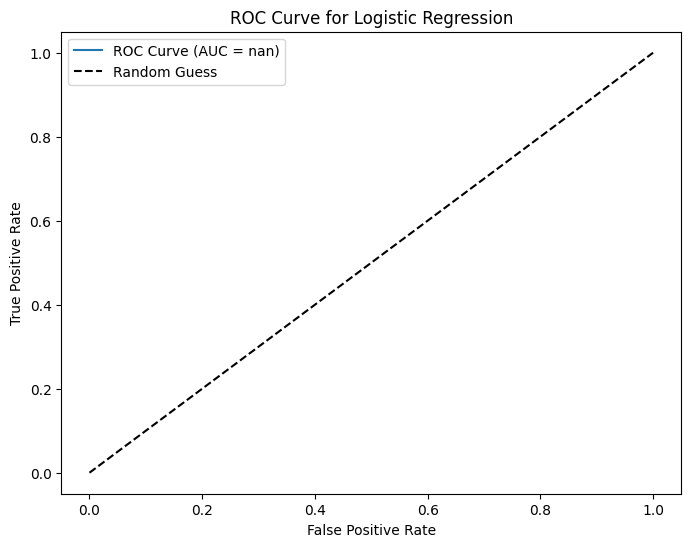

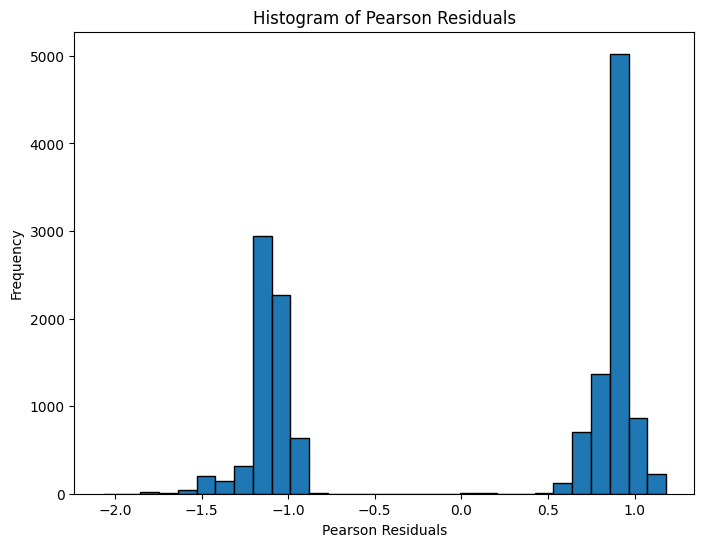

Influence plot not available for Logit models: 'MLEInfluence' object has no attribute 'resid_studentized_external'


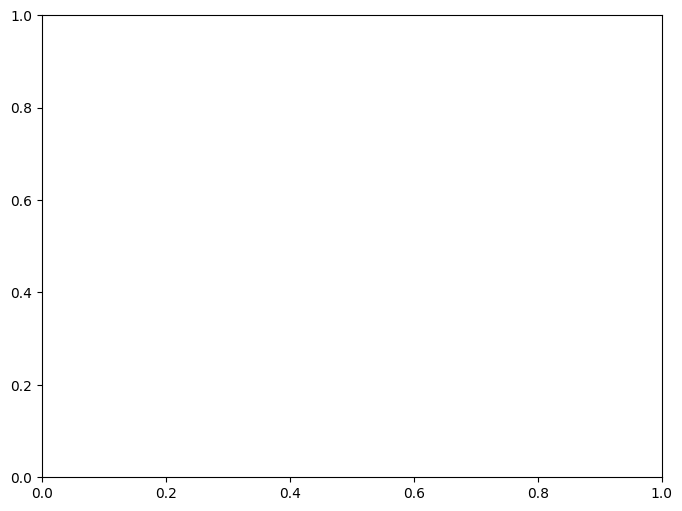

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# =============================================================================
# 1. Fit the Logistic Regression Model Using statsmodels
# =============================================================================
# Assume that X_train (predictors) and y_train (binary target) are defined.
# For example, X_train might be your DataFrame of features and y_train a Series.
# Add a constant (intercept)
X_train_sm = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()  # This prints the optimization output
print(result.summary())

# =============================================================================
# 2. Check for Multicollinearity with Variance Inflation Factor (VIF)
# =============================================================================
vif_data = pd.DataFrame({
    "Feature": X_train.columns,
    "VIF": [variance_inflation_factor(X_train.values, i)
            for i in range(X_train.shape[1])]
})
print("\nVariance Inflation Factors (VIF):")
print(vif_data)

# =============================================================================
# 3. Prepare the Test Set for Prediction (Align Columns)
# =============================================================================
# Assume X_test and y_test (test set predictors and target) are defined.
X_test_sm = sm.add_constant(X_test)
# Align test columns with those used in training
X_test_sm = X_test_sm.reindex(columns=X_train_sm.columns, fill_value=0)

# =============================================================================
# 4. Generate Predictions and Compute Diagnostics on the Test Set
# =============================================================================
# Get predicted probabilities from the fitted model
y_pred_prob = result.predict(X_test_sm)
# Convert probabilities to binary predictions (using 0.5 threshold)
y_pred = (y_pred_prob > 0.5).astype(int)

# a) Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# b) ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='best')
plt.show()

# =============================================================================
# 5. Additional Diagnostics: Residual Analysis
# =============================================================================
# a) Histogram of Pearson Residuals
residuals = result.resid_pearson
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Pearson Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Pearson Residuals')
plt.show()

# =============================================================================
# 6. Attempt an Influence Plot with a Try/Except Block
# =============================================================================
try:
    fig, ax = plt.subplots(figsize=(8, 6))
    sm.graphics.influence_plot(result, ax=ax, criterion="cooks")
    plt.title("Influence Plot (Cook's Distance)")
    plt.show()
except AttributeError as e:
    print("Influence plot not available for Logit models:", e)


# Model 5 Logistic Double-scaled

In [1]:
# Mount Google Drive (run this cell first in Colab)
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import os

# =============================================================================
# 1. Load and Prepare the Double-Scaled Dataset (Final 44)
# =============================================================================
file_path = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 44.xlsx"
df = pd.read_excel(file_path)

# Check for required columns
required_columns = ["Return_Next 3M", "Timestamp", "PERMNO"]
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' is missing in the Final 44 database.")

# Drop rows with missing target values and reset index
df = df.dropna(subset=["Return_Next 3M"]).reset_index(drop=True)

# Ensure the Timestamp column is integer
df["Timestamp"] = df["Timestamp"].astype(int)

# (Optional) Inspect a few rows and statistics to confirm double scaling
print("Head of the dataset:")
print(df.head())
print("\nSummary statistics:")
print(df.describe())

# Create the binary target for logistic regression:
# Classify as 1 if "Return_Next 3M" > 0, else 0.
df["target"] = (df["Return_Next 3M"] > 0).astype(int)

# Define non-feature columns and select predictors (features)
non_feature_cols = ["Return_Next 3M", "Timestamp", "PERMNO", "target"]
x_vars = [col for col in df.columns if col not in non_feature_cols]

# =============================================================================
# 2. Define Moving Window Parameters and Split Ranges
# =============================================================================
# Window lengths (measured in unique Timestamp units)
rolling_window = 36      # Training period length
validation_period = 3    # Validation period length
test_period = 2          # Test period length

# Get the sorted list of unique timestamps
timestamps = sorted(df["Timestamp"].unique())

# Storage for window-specific results and predictions
results = []

# =============================================================================
# 3. Moving Window Loop (Avoiding Data Leakage)
# =============================================================================
for i in range(len(timestamps) - rolling_window - validation_period - test_period + 1):
    # Define time boundaries for each split:
    train_start = timestamps[i]
    train_end = timestamps[i + rolling_window - 1]
    validation_start = timestamps[i + rolling_window]
    validation_end = timestamps[i + rolling_window + validation_period - 1]
    test_start = timestamps[i + rolling_window + validation_period]
    test_end = timestamps[i + rolling_window + validation_period + test_period - 1]

    # Select data for each period based on Timestamp
    train_data = df[(df["Timestamp"] >= train_start) & (df["Timestamp"] <= train_end)]
    validation_data = df[(df["Timestamp"] >= validation_start) & (df["Timestamp"] <= validation_end)]
    test_data = df[(df["Timestamp"] >= test_start) & (df["Timestamp"] <= test_end)]

    # Debug: Print the number of observations in each period
    print(f"Window ending at Timestamp {train_end}: Train: {len(train_data)}, "
          f"Validation: {len(validation_data)}, Test: {len(test_data)}")

    # Skip the window if any period has insufficient data
    if len(train_data) < rolling_window or len(validation_data) == 0 or len(test_data) == 0:
        print(f"Skipping window ending at {train_end} due to insufficient data.")
        continue

    # Prepare feature and target sets for training, validation, and test splits
    X_train = train_data[x_vars]
    y_train = train_data["target"]
    X_validation = validation_data[x_vars]
    y_validation = validation_data["target"]
    X_test = test_data[x_vars]
    y_test = test_data["target"]

    # Skip if there are any NaN values in the training split or if the target is constant
    if X_train.isnull().values.any() or y_train.isnull().values.any():
        print(f"Skipping window ending at {train_end} due to NaN values.")
        continue

    if y_train.nunique() == 1:
        print(f"Skipping window ending at {train_end} due to constant target variable.")
        continue

    # =============================================================================
    # 4. Train Logistic Regression Model on the Current Window
    # =============================================================================
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # Generate predictions on the validation and test sets
    val_preds = model.predict(X_validation)
    val_probs = model.predict_proba(X_validation)[:, 1]
    test_preds = model.predict(X_test)
    test_probs = model.predict_proba(X_test)[:, 1]

    # Compute performance metrics (accuracy and ROC-AUC)
    val_accuracy = accuracy_score(y_validation, val_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    try:
        val_roc_auc = roc_auc_score(y_validation, val_probs)
        test_roc_auc = roc_auc_score(y_test, test_probs)
    except ValueError:
        val_roc_auc = np.nan
        test_roc_auc = np.nan

    # Save the results and predictions for later analysis
    results.append({
        "train_end": train_end,
        "validation_accuracy": val_accuracy,
        "test_accuracy": test_accuracy,
        "validation_roc_auc": val_roc_auc,
        "test_roc_auc": test_roc_auc,
        "model": model,  # Stored for reference if needed
        "validation_data": validation_data.assign(predicted_prob=val_probs),
        "test_data": test_data.assign(predicted_prob=test_probs)
    })

    print(f"Window ending {train_end}: Val Acc = {val_accuracy:.2f}, Test Acc = {test_accuracy:.2f}, "
          f"Val ROC-AUC = {val_roc_auc:.2f}, Test ROC-AUC = {test_roc_auc:.2f}")

# =============================================================================
# 5. Finalize and Save Results as Final 49.xlsx
# =============================================================================
if len(results) == 0:
    raise ValueError("No valid predictions were generated. Please check your window parameters or data quality.")

# Concatenate all the validation and test predictions
all_val_preds = pd.concat([res["validation_data"] for res in results], ignore_index=True)
all_test_preds = pd.concat([res["test_data"] for res in results], ignore_index=True)

# Save the final predictions to a single Excel file with separate sheets
output_file = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 49.xlsx"
with pd.ExcelWriter(output_file) as writer:
    all_val_preds.to_excel(writer, sheet_name="Validation", index=False)
    all_test_preds.to_excel(writer, sheet_name="Test", index=False)

print("✅ Logistic Regression on Final 44 (double-scaled) dataset completed!")
print(f"Results saved as: {output_file}")


Mounted at /content/drive
Head of the dataset:
   Return_Next 3M  PERMNO  Timestamp        PS        PB       EVM  \
0       -0.307304   10104     200301  2.768515  4.448275  0.428147   
1        0.343411   64899     200301 -0.541549 -0.870503  0.176553   
2        0.017369   89014     200301  0.143823  0.990321  0.217516   
3       -0.627125   21207     200301  1.599059 -0.261285  0.443110   
4       -0.392099   10145     200301 -0.148417 -0.222877  0.210876   

   PCA_Valuation_PE_1  PCA_Valuation_PE_2  PCA_Profitability_1  \
0            0.811970            0.518688             1.512405   
1           -0.504641           -0.081161            -0.030806   
2            0.007931            0.055236             0.245613   
3            2.188882           -1.594530            -0.266878   
4           -0.148662            0.319950            -0.094775   

   PCA_Leverage_1  PCA_Liquidity_1  PCA_Efficiency_1  \
0       -0.408748        -0.532095         -0.031670   
1        0.351292      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Window ending 202306: Val Acc = 0.49, Test Acc = 1.00, Val ROC-AUC = 0.46, Test ROC-AUC = nan
Window ending at Timestamp 202307: Train: 14931, Validation: 829, Test: 2
Window ending 202307: Val Acc = 0.40, Test Acc = 1.00, Val ROC-AUC = 0.42, Test ROC-AUC = nan
✅ Logistic Regression on Final 44 (double-scaled) dataset completed!
Results saved as: /content/drive/My Drive/Colab Notebooks/823 Project/Final 49.xlsx


Summary of Rolling Window Metrics:
           train_end     val_acc    test_acc  val_roc_auc  test_roc_auc
count     212.000000  212.000000  212.000000   212.000000    210.000000
mean   201431.915094    0.498720    0.498013     0.508510      0.502434
std       511.776927    0.100021    0.114475     0.061944      0.074004
min    200512.000000    0.181079    0.166297     0.349865      0.294381
25%    201004.750000    0.446023    0.435410     0.462781      0.451518
50%    201409.500000    0.497765    0.506316     0.518642      0.514439
75%    201902.250000    0.549309    0.559760     0.553895      0.553393
max    202307.000000    0.878049    1.000000     0.630665      0.681632


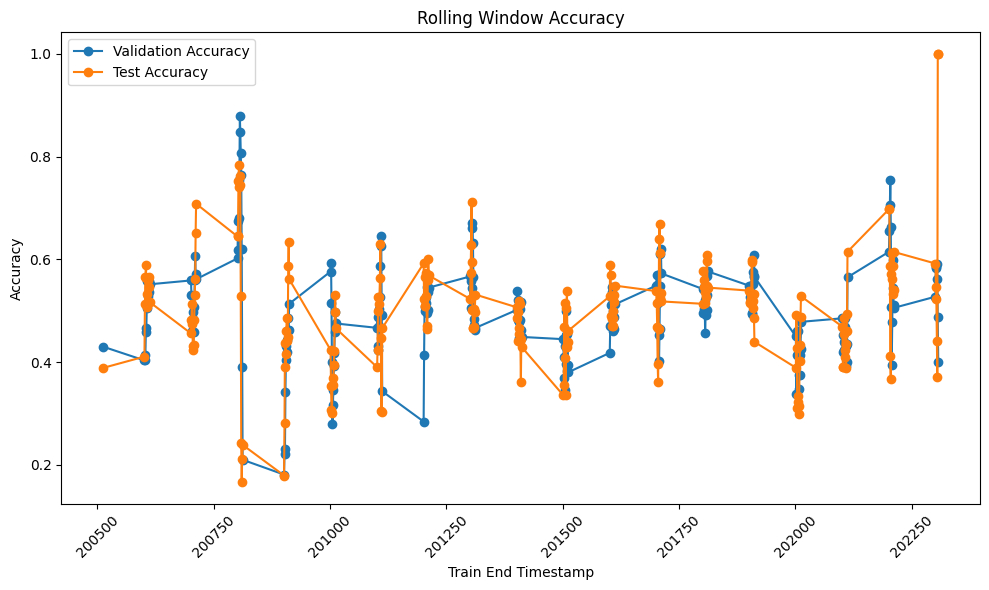

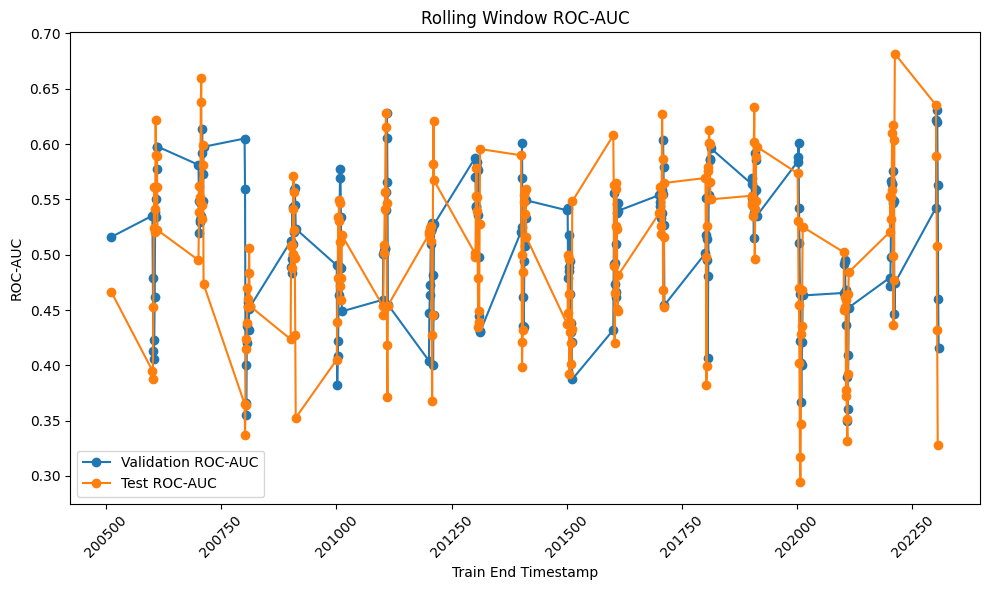

Summary of Model Coefficients Across Rolling Windows:
           train_end   intercept          PS          PB         EVM  \
count     212.000000  212.000000  212.000000  212.000000  212.000000   
mean   201431.915094   -0.047711    0.054536    0.015318    0.099644   
std       511.776927    0.295748    0.086469    0.040035    0.903523   
min    200512.000000   -0.536420   -0.168000   -0.075829   -2.343878   
25%    201004.750000   -0.285322    0.026047   -0.003940   -0.329526   
50%    201409.500000   -0.134947    0.053846    0.015072    0.342405   
75%    201902.250000    0.287910    0.087106    0.032393    0.741916   
max    202307.000000    0.520461    0.235944    0.112840    1.449119   

       PCA_Valuation_PE_1  PCA_Valuation_PE_2  PCA_Profitability_1  \
count          212.000000          212.000000           212.000000   
mean            -0.047394           -0.017139            -0.082338   
std              0.043203            0.055411             0.089206   
min             -

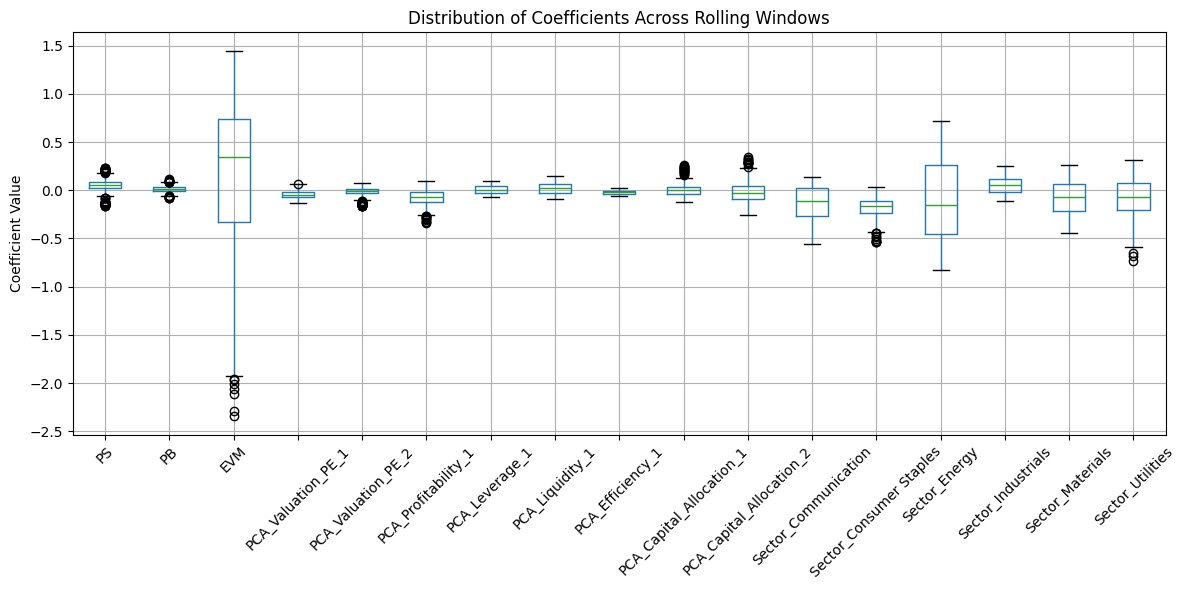

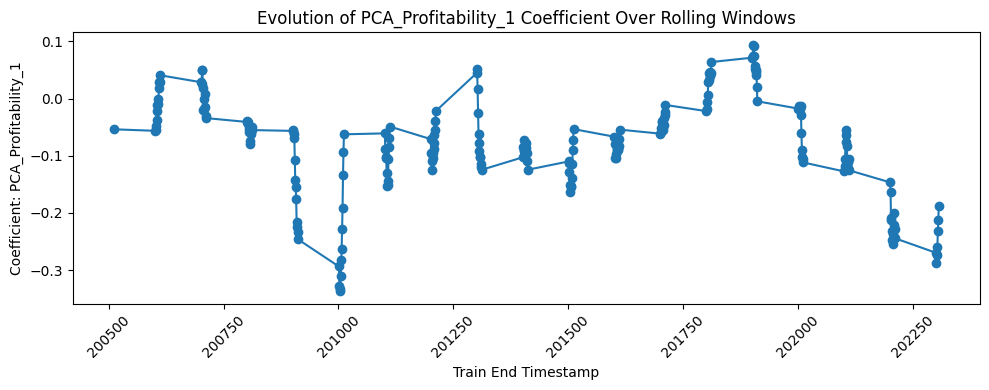

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# 1. Aggregate Rolling Metrics into a DataFrame
# =============================================================================
# Build a DataFrame that summarizes the key metrics from each rolling window.
metrics = pd.DataFrame([{
    "train_end": res["train_end"],
    "val_acc": res["validation_accuracy"],
    "test_acc": res["test_accuracy"],
    "val_roc_auc": res["validation_roc_auc"],
    "test_roc_auc": res["test_roc_auc"]
} for res in results])

# If your train_end timestamps are integers (e.g., 200512, 200601, etc.) you might convert
# them to a datetime format if desired; otherwise, they can be treated as an ordered index.
# For example, if they represent YYYYMM:
# metrics['train_end'] = pd.to_datetime(metrics['train_end'].astype(str) + '01', format='%Y%m%d')

print("Summary of Rolling Window Metrics:")
print(metrics.describe())

# =============================================================================
# 2. Plot Performance Metrics Over Time
# =============================================================================
plt.figure(figsize=(10, 6))
plt.plot(metrics["train_end"], metrics["val_acc"], marker="o", linestyle="-", label="Validation Accuracy")
plt.plot(metrics["train_end"], metrics["test_acc"], marker="o", linestyle="-", label="Test Accuracy")
plt.xlabel("Train End Timestamp")
plt.ylabel("Accuracy")
plt.title("Rolling Window Accuracy")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(metrics["train_end"], metrics["val_roc_auc"], marker="o", linestyle="-", label="Validation ROC-AUC")
plt.plot(metrics["train_end"], metrics["test_roc_auc"], marker="o", linestyle="-", label="Test ROC-AUC")
plt.xlabel("Train End Timestamp")
plt.ylabel("ROC-AUC")
plt.title("Rolling Window ROC-AUC")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =============================================================================
# 3. Summarize Model Coefficients Across Rolling Windows
# =============================================================================
# We assume that the logistic models are built with the same set and order of predictors.
# (The list 'x_vars' contains the names of the predictors.)
coef_list = []
for res in results:
    model = res["model"]
    coef_dict = {}
    coef_dict["train_end"] = res["train_end"]
    # Extract intercept and coefficients from the scikit-learn model.
    coef_dict["intercept"] = model.intercept_[0]
    for idx, feature in enumerate(x_vars):
        coef_dict[feature] = model.coef_[0, idx]
    coef_list.append(coef_dict)

coef_df = pd.DataFrame(coef_list)

print("Summary of Model Coefficients Across Rolling Windows:")
print(coef_df.describe())

# Plot boxplots for the coefficients of the predictors
plt.figure(figsize=(12, 6))
coef_df.boxplot(column=x_vars, rot=45)
plt.title("Distribution of Coefficients Across Rolling Windows")
plt.ylabel("Coefficient Value")
plt.tight_layout()
plt.show()

# Optionally, you can plot the evolution of a single coefficient over time.
# For example, to track 'PCA_Profitability_1':
plt.figure(figsize=(10, 4))
plt.plot(coef_df["train_end"], coef_df["PCA_Profitability_1"], marker="o", linestyle="-")
plt.xlabel("Train End Timestamp")
plt.ylabel("Coefficient: PCA_Profitability_1")
plt.title("Evolution of PCA_Profitability_1 Coefficient Over Rolling Windows")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


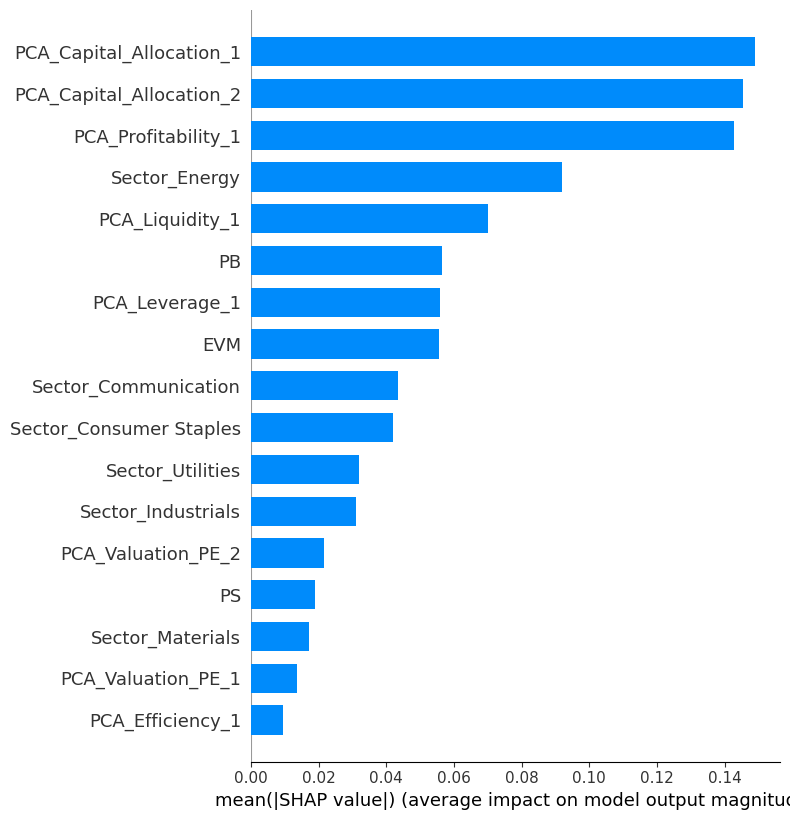

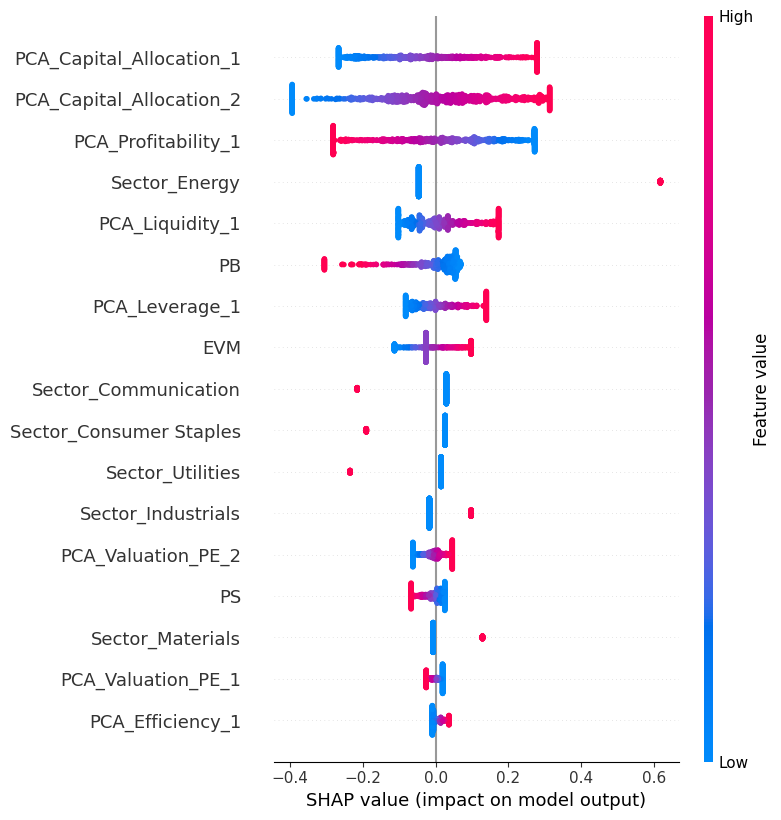

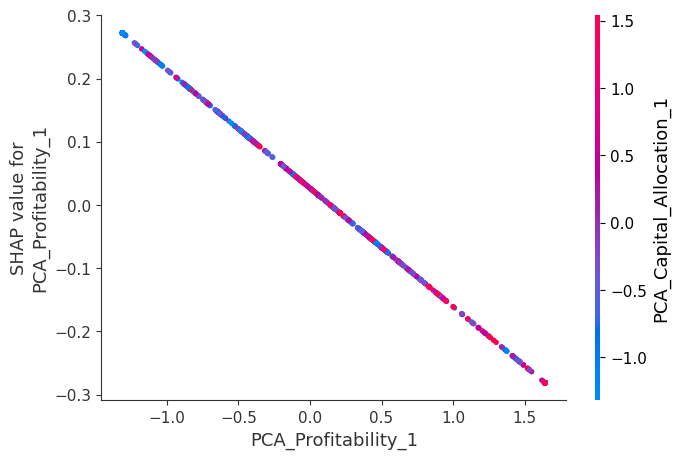

In [4]:
# Install SHAP if you haven't already
!pip install shap

import shap

# Select one rolling window result (e.g., the last window) for analysis.
selected_result = results[-1]
model = selected_result["model"]

# Choose the dataset for explanation; here we use the validation set.
X_val = selected_result["validation_data"][x_vars]

# For linear models like logistic regression, you can use LinearExplainer.
# The "interventional" option is recommended for more accurate attributions.
explainer = shap.LinearExplainer(model, X_val, feature_perturbation="interventional")

# Compute SHAP values for the validation data.
shap_values = explainer.shap_values(X_val)

# Plot a summary bar plot to show the mean absolute impact of each feature.
shap.summary_plot(shap_values, X_val, plot_type="bar", feature_names=x_vars)

# Alternatively, you can plot a beeswarm summary plot that shows the distribution of the impacts.
shap.summary_plot(shap_values, X_val, feature_names=x_vars)

# Optionally, create a dependence plot for a single feature, for example 'PCA_Profitability_1'.
shap.dependence_plot("PCA_Profitability_1", shap_values, X_val, feature_names=x_vars)


In [5]:
import shap
import pandas as pd
import numpy as np

# Select one rolling window result (e.g., the last window)
selected_result = results[-1]
model = selected_result["model"]

# Select the validation data for explanation using the predictor columns (x_vars)
X_val = selected_result["validation_data"][x_vars]

# Create a SHAP explainer for your linear model using the "interventional" approach
explainer = shap.LinearExplainer(model, X_val, feature_perturbation="interventional")

# Compute SHAP values for the validation data
shap_values = explainer.shap_values(X_val)

# Convert the SHAP values into a DataFrame for easier viewing
shap_df = pd.DataFrame(shap_values, columns=x_vars)

# Display the first few rows of the SHAP values
print("SHAP values for the first 5 samples:")
print(shap_df.head())

# Compute and display summary statistics of the SHAP values
shap_summary = shap_df.describe()
print("\nSummary statistics of SHAP values:")
print(shap_summary)

# Optionally, compute the mean absolute SHAP value for each feature
mean_abs_shap = shap_df.abs().mean()
print("\nMean absolute SHAP values for each feature:")
print(mean_abs_shap)


SHAP values for the first 5 samples:
         PS        PB       EVM  PCA_Valuation_PE_1  PCA_Valuation_PE_2  \
0  0.025150  0.065572 -0.026749            0.018006            0.003355   
1 -0.009259  0.030073 -0.026749            0.008304            0.000450   
2  0.025346  0.067657 -0.026749            0.019247           -0.001264   
3 -0.039086 -0.305918  0.020368           -0.009168           -0.012238   
4 -0.038451 -0.305918  0.021572           -0.008871           -0.011794   

   PCA_Profitability_1  PCA_Leverage_1  PCA_Liquidity_1  PCA_Efficiency_1  \
0             0.272303        0.005258         0.000129          0.014015   
1            -0.260068       -0.071709         0.173218         -0.009104   
2             0.272303        0.086848        -0.102548          0.018791   
3            -0.281722        0.139425         0.033791         -0.007715   
4            -0.281722        0.139425         0.033791         -0.007715   

   PCA_Capital_Allocation_1  PCA_Capital_Allocati

/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=01368843d7eca26009b588785fdf4dd4af8524d61320c6b8a009726d86457736
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

LIME Explanation for sample 0:
Sector_Energy <= 0.00: -0.1629232299157573
PCA_Capital_Allocation_2 <= -0.26: -0.07524877087419025
PCA_Profitability_1 <= -0.50: 0.06629030164850094
Sector_Utilities <= 0.00: 0.06203937762672866
Sector_Communication > 0.00: -0.059081760705345286
Sector_Consumer Staples <= 0.00: 0.05128071154473494
Sector_Materials <= 0.00: -0.03358703861733355
EVM <= 0.30: -0.02992192305344874
Sector_Industrials <= 0.00: -0.02749232154788883
-0.74 < PCA_Capital_Allocation_1 <= -0.02: -0.02062969974761072
PB <= -0.25: 0.019437332051374642
PCA_Valuation_PE_1 <= -1.56: 0.007647956102092698
PS <= -0.85: 0.006521097900649585
0.08 < PCA_Liquidity_1 <= 0.70: 0.005961502211574868
PCA_Efficiency_1 > 0.71: 0.004900622849706637
0.37 < PCA_Valuation_PE_2 <= 0.90: 0.0019365627178651887
0.14 < PCA_Leverage_1 <= 0.88: 0.00013665316688895937


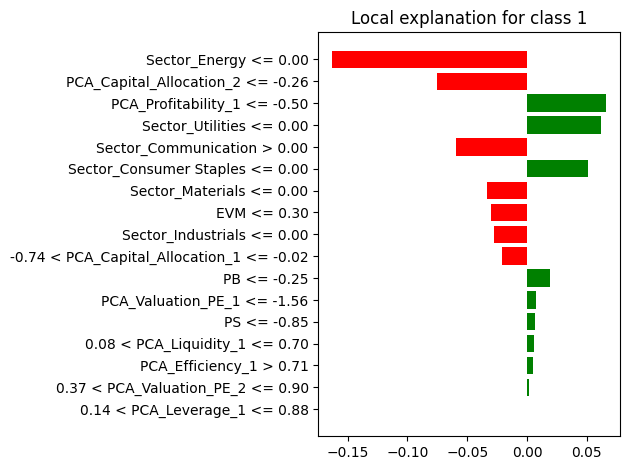

In [6]:
# Install LIME if not already installed
!pip install lime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular

# Select one rolling window result (e.g., the last one) for LIME analysis
selected_result = results[-1]
model = selected_result["model"]

# Use the validation data for explanation; make sure you use the predictors defined in x_vars.
X_val = selected_result["validation_data"][x_vars]
X_train = X_val  # For simplicity, we use the same validation data as the training data for LIME.

# Create a LimeTabularExplainer. Here, we specify the mode as 'classification'
# and pass the predictor names and training data.
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=x_vars,
    class_names=["0", "1"],
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

# Choose one sample from the validation set (e.g., the first instance)
instance = X_val.iloc[0]

# Explain the prediction for this instance. We ask for all features in the explanation.
explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=model.predict_proba,
    num_features=len(x_vars)
)

# Get LIME values as a list of tuples (feature, weight)
lime_values = explanation.as_list()
print("LIME Explanation for sample 0:")
for feature, weight in lime_values:
    print(f"{feature}: {weight}")

# Plot the explanation graph with a white background
fig = explanation.as_pyplot_figure()
fig.set_facecolor("white")
plt.tight_layout()
plt.show()
